# Detection

In [39]:
# Todo
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import matplotlib.patches as patches


### Load data and preprocessing

In [40]:
SEED = 265
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inngangsbildestørrelse og grid-dimensjoner
H_in, W_in = 48, 60  # Bildestørrelse
H_out, W_out = 2, 3   # Grid: 2 rader og 3 kolonner

# Last inn data (bilder og labels)
imgs_train = torch.load("data/data/detection_train.pt")
imgs_val   = torch.load("data/data/detection_val.pt")
imgs_test  = torch.load("data/data/detection_test.pt")

# Ekstraher bildene fra tuple-dataene og stable dem
train_images = torch.stack([img for img, _ in imgs_train])
val_images   = torch.stack([img for img, _ in imgs_val])
test_images  = torch.stack([img for img, _ in imgs_test])

# Sjekk om bildedataene mangler kanal-dimensjon; legg til hvis nødvendig
if train_images.dim() == 3:
    train_images = train_images.unsqueeze(1)
if val_images.dim() == 3:
    val_images = val_images.unsqueeze(1)
if test_images.dim() == 3:
    test_images = test_images.unsqueeze(1)

# Last inn uprosesserte labels (liste med lister med tensorer: [pc, x, y, w, h, c])
y_true_train = torch.load("data/data/list_y_true_train.pt")
y_true_val   = torch.load("data/data/list_y_true_val.pt")
y_true_test  = torch.load("data/data/list_y_true_test.pt")

# Funksjon for å konvertere labels til grid-format (N, H_out, W_out, 6)
def convert_to_grid(y_true_list, H_out=2, W_out=3, img_h=48, img_w=60):
    N = len(y_true_list)
    y_true_grid = torch.zeros((N, H_out, W_out, 6))
    for img_idx, objects in enumerate(y_true_list):
        for obj in objects:
            pc, x, y, w, h, c = obj
            grid_h = int(y * H_out)
            grid_w = int(x * W_out)
            # Beregn lokale koordinater i grid-cellen
            x_local = (x - (grid_w / W_out)) * W_out
            y_local = (y - (grid_h / H_out)) * H_out
            w_local = w * W_out
            h_local = h * H_out
            y_true_grid[img_idx, grid_h, grid_w] = torch.tensor([1, x_local, y_local, w_local, h_local, c])
    return y_true_grid

# Konverter labels til grid-format
labels_train = convert_to_grid(y_true_train, H_out, W_out, H_in, W_in)
labels_val   = convert_to_grid(y_true_val, H_out, W_out, H_in, W_in)
labels_test  = convert_to_grid(y_true_test, H_out, W_out, H_in, W_in)

# Opprett TensorDatasets og DataLoaders
train_dataset = TensorDataset(train_images, labels_train)
val_dataset   = TensorDataset(val_images, labels_val)
test_dataset  = TensorDataset(test_images, labels_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test utskrift
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: torch.Size([32, 1, 48, 60]), Labels shape: torch.Size([32, 2, 3, 6])


### Normalize Images

In [41]:

mean = train_images.mean()
std = train_images.std()
normalize_transform = transforms.Normalize(mean, std)

# Normaliser alle bildedataene
train_images = normalize_transform(train_images)
val_images   = normalize_transform(val_images)
test_images  = normalize_transform(test_images)

In [42]:

class DetectNet(nn.Module):
    def __init__(self, num_classes=2, H_out=2, W_out=3):
        super(DetectNet, self).__init__()
        self.num_classes = num_classes
        self.out_channels = num_classes + 5  # (pc, x, y, w, h, c)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.conv_out = nn.Conv2d(64, self.out_channels, kernel_size=3, padding=0)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x

class DetectNetSmall(nn.Module):
    def __init__(self):
        super(DetectNetSmall, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   # (48,60) -> (24,30)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)   # (24,30) -> (12,15)
        self.pool3 = nn.MaxPool2d(kernel_size=(6, 5), stride=(6, 5))  # (12,15) -> (2,3)
        self.conv_out = nn.Conv2d(16, 7, 1)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x

class DetectNetLarger(nn.Module):
    def __init__(self):
        super(DetectNetLarger, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(6, 5), stride=(6, 5))
        self.conv_out = nn.Conv2d(64, 7, 1)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.conv_out(x)
        return x
class ImprovedDetectNet(nn.Module):
    def __init__(self, num_classes=2, H_out=2, W_out=3):
        super(ImprovedDetectNet, self).__init__()
        self.num_classes = num_classes
        self.out_channels = num_classes + 5
        # Økte antall filtre for bedre representasjon
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 3)
        self.conv_out = nn.Conv2d(128, self.out_channels, kernel_size=3, padding=0)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.conv_out(x)
        return x


### Training

In [43]:
def detection_loss(y_pred, y_true):
    y_pred = y_pred.permute(0, 2, 3, 1)  # Endre dimensjoner til (N, H_out, W_out, C+5)
    loss_pc = nn.BCEWithLogitsLoss()(y_pred[:, :, :, 0], y_true[:, :, :, 0])
    loss_bbox = torch.where(
        y_true[:, :, :, 0] == 1,
        nn.MSELoss(reduction='none')(y_pred[:, :, :, 1:5], y_true[:, :, :, 1:5]).mean(dim=-1),
        torch.zeros_like(y_true[:, :, :, 0])
    ).mean()
    mask = y_true[:, :, :, 0] == 1
    pred_classes = y_pred[:, :, :, 5:][mask]
    true_classes = y_true[:, :, :, -1][mask].long()
    if pred_classes.shape[0] > 0:
        loss_class = nn.CrossEntropyLoss()(pred_classes, true_classes)
    else:
        loss_class = torch.tensor(0.0, device=y_pred.device)
    return loss_pc + loss_bbox + loss_class

def train_detection_model(model, train_loader, val_loader, optimizer, num_epochs=50, early_stop_patience=7):
    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            preds = model(images)
            loss = detection_loss(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                preds = model(images)
                val_loss += detection_loss(preds, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

### Prediction

In [44]:

def plot_predictions(model, loader, num_images=5):
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    model.eval()
    images, labels = next(iter(loader))
    preds = model(images.to(DEVICE)).cpu().detach()
    preds = preds.permute(0, 2, 3, 1)  # (N, H_out, W_out, C+5)
    for i in range(num_images):
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap="gray")
        for h in range(H_out):
            for w in range(W_out):
                if labels[i, h, w, 0].item() == 0:
                    continue
                true_bb = labels[i, h, w, 1:5].cpu().numpy()
                pred_bb = preds[i, h, w, 1:5].cpu().numpy()
                plt.gca().add_patch(plt.Rectangle(
                    (true_bb[0] * W_in - true_bb[2] * W_in / 2, true_bb[1] * H_in - true_bb[3] * H_in / 2),
                    true_bb[2] * W_in, true_bb[3] * H_in,
                    edgecolor='green', linewidth=2, fill=False))
                plt.gca().add_patch(plt.Rectangle(
                    (pred_bb[0] * W_in - pred_bb[2] * W_in / 2, pred_bb[1] * H_in - pred_bb[3] * H_in / 2),
                    pred_bb[2] * W_in, pred_bb[3] * H_in,
                    edgecolor='red', linewidth=2, fill=False))
        plt.show()


### Model selection and evaluation

In [45]:
def IoU(box1, box2):
    """
    Beregn Intersection over Union (IoU) for to bounding boxes.
    Hver boks er definert som [x, y, w, h], der (x, y) er senterkoordinat.
    """
    # Konverter fra senter-koordinater til hjørner
    box1_x1 = box1[0] - box1[2] / 2
    box1_y1 = box1[1] - box1[3] / 2
    box1_x2 = box1[0] + box1[2] / 2
    box1_y2 = box1[1] + box1[3] / 2

    box2_x1 = box2[0] - box2[2] / 2
    box2_y1 = box2[1] - box2[3] / 2
    box2_x2 = box2[0] + box2[2] / 2
    box2_y2 = box2[1] + box2[3] / 2

    # Finn skjæringsområdet
    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)

    if inter_x2 < inter_x1 or inter_y2 < inter_y1:
        return 0.0

    intersection = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    union = (box1[2] * box1[3]) + (box2[2] * box2[3]) - intersection
    return intersection / union if union > 0 else 0.0

def compute_IoU_detection(model, loader, preprocessor=None):
    model.eval()
    total_iou = 0
    count = 0
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            preds = preds.permute(0, 2, 3, 1)
            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:
                            iou = IoU(preds[i, h, w, 1:5].cpu().numpy(), labels[i, h, w, 1:5].cpu().numpy())
                            total_iou += iou
                            count += 1
    avg_iou = total_iou / count if count > 0 else 0
    print(f"Average IoU: {avg_iou:.4f}")
    return avg_iou

def compute_accuracy_detection(model, loader, preprocessor=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            preds = preds.permute(0, 2, 3, 1)
            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:
                            pred_class = preds[i, h, w, 5:].argmax().item()
                            true_class = labels[i, h, w, -1].item()
                            if pred_class == true_class:
                                correct += 1
                            total += 1
    accuracy = correct / total if total > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

def plot_images_with_bboxes(model, dataset, indices=None, num_images=5):
    model.eval()
    if indices is None:
        indices = random.sample(range(len(dataset)), num_images)
    
    for idx in indices:
        image, label = dataset[idx]  # label har form [H_out, W_out, 6]
        image_input = image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            preds = model(image_input)
        preds = preds.permute(0, 2, 3, 1)[0].cpu()
        
        plt.figure()
        plt.imshow(image.squeeze().cpu().numpy(), cmap="gray")
        plt.title(f"Image index {idx}")
        
        for h in range(H_out):
            for w in range(W_out):
                if label[h, w, 0].item() < 0.5:
                    continue
                
                true_bb = label[h, w, 1:5].cpu().numpy()
                pred_bb = preds[h, w, 1:5].numpy()
                
                cell_w = W_in / W_out
                cell_h = H_in / H_out
                cell_x = w * cell_w
                cell_y = h * cell_h
                
                true_center_x = cell_x + true_bb[0] * cell_w
                true_center_y = cell_y + true_bb[1] * cell_h
                true_w = true_bb[2] * W_in
                true_h = true_bb[3] * H_in
                
                pred_center_x = cell_x + pred_bb[0] * cell_w
                pred_center_y = cell_y + pred_bb[1] * cell_h
                pred_w = pred_bb[2] * W_in
                pred_h = pred_bb[3] * H_in
                
                plt.gca().add_patch(patches.Rectangle(
                    (true_center_x - true_w/2, true_center_y - true_h/2),
                    true_w, true_h, edgecolor='green', linewidth=2, fill=False))
                
                plt.gca().add_patch(patches.Rectangle(
                    (pred_center_x - pred_w/2, pred_center_y - pred_h/2),
                    pred_w, pred_h, edgecolor='red', linewidth=2, fill=False))
        plt.show()
        
def find_best_and_worst_predictions(model, dataset, n_samples=5):
    model.eval()
    results = []
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        image_input = image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            preds = model(image_input)
        preds = preds.permute(0, 2, 3, 1)[0].cpu()
        
        total_iou = 0.0
        count = 0
        for h in range(H_out):
            for w in range(W_out):
                if label[h, w, 0].item() < 0.5:
                    continue
                true_bb = label[h, w, 1:5].cpu().numpy()
                pred_bb = preds[h, w, 1:5].numpy()
                
                cell_w = W_in / W_out
                cell_h = H_in / H_out
                cell_x = w * cell_w
                cell_y = h * cell_h
                
                true_center = [cell_x + true_bb[0] * cell_w, cell_y + true_bb[1] * cell_h]
                true_box = [true_center[0], true_center[1], true_bb[2] * W_in, true_bb[3] * H_in]
                
                pred_center = [cell_x + pred_bb[0] * cell_w, cell_y + pred_bb[1] * cell_h]
                pred_box = [pred_center[0], pred_center[1], pred_bb[2] * W_in, pred_bb[3] * H_in]
                
                iou_val = IoU(pred_box, true_box)
                total_iou += iou_val
                count += 1
        
        avg_iou = total_iou / count if count > 0 else 0.0
        results.append((idx, avg_iou))
    
    results.sort(key=lambda x: x[1])
    worst_indices = [x[0] for x in results[:n_samples]]
    best_indices = [x[0] for x in results[-n_samples:]][::-1]
    return best_indices, worst_indices


### Main Execution

In [46]:
# Trening av flere modeller, inkludert improved_model
model_classes = [DetectNetSmall, DetectNet, DetectNetLarger,ImprovedDetectNet]
trained_models = []
for model_class in model_classes:
    print(f"\nTraining {model_class.__name__} with hyperparameters")
    temp_model = model_class().to(DEVICE)
    optimizer = optim.Adam(temp_model.parameters(), lr=0.001, weight_decay=0.0001)
    train_detection_model(temp_model, train_loader, val_loader, optimizer)
    iou_val = compute_IoU_detection(temp_model, test_loader)
    acc_val = compute_accuracy_detection(temp_model, test_loader)
    trained_models.append({
        "model": temp_model,
        "model_name": model_class.__name__,
        "iou": iou_val,
        "accuracy": acc_val
    })

print("\n===== MODEL COMPARISON =====")
for model_info in trained_models:
    print(f"Model: {model_info['model_name']}")
    print(f"  IoU: {model_info['iou']:.4f}")
    print(f"  Accuracy: {model_info['accuracy']:.4f}")

# Velg den modellen med høyest IoU som best_model (kan kombineres med accuracy om ønskelig)
best_model = max(trained_models, key=lambda x: x["iou"])["model"]



Training DetectNetSmall with hyperparameters
Epoch 1/50 | Train Loss: 0.7083 | Val Loss: 0.4494
Epoch 2/50 | Train Loss: 0.4120 | Val Loss: 0.3710
Epoch 3/50 | Train Loss: 0.3503 | Val Loss: 0.3314
Epoch 4/50 | Train Loss: 0.3257 | Val Loss: 0.3142
Epoch 5/50 | Train Loss: 0.3122 | Val Loss: 0.3051
Epoch 6/50 | Train Loss: 0.3009 | Val Loss: 0.2893
Epoch 7/50 | Train Loss: 0.2928 | Val Loss: 0.2845
Epoch 8/50 | Train Loss: 0.2859 | Val Loss: 0.2784
Epoch 9/50 | Train Loss: 0.2796 | Val Loss: 0.2708
Epoch 10/50 | Train Loss: 0.2720 | Val Loss: 0.2709
Epoch 11/50 | Train Loss: 0.2656 | Val Loss: 0.2609
Epoch 12/50 | Train Loss: 0.2595 | Val Loss: 0.2512
Epoch 13/50 | Train Loss: 0.2543 | Val Loss: 0.2503
Epoch 14/50 | Train Loss: 0.2512 | Val Loss: 0.2456
Epoch 15/50 | Train Loss: 0.2481 | Val Loss: 0.2414
Epoch 16/50 | Train Loss: 0.2452 | Val Loss: 0.2384
Epoch 17/50 | Train Loss: 0.2437 | Val Loss: 0.2391
Epoch 18/50 | Train Loss: 0.2416 | Val Loss: 0.2383
Epoch 19/50 | Train Loss: 0

### Predition 

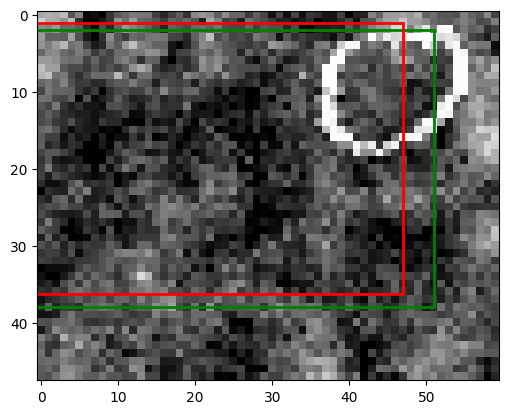

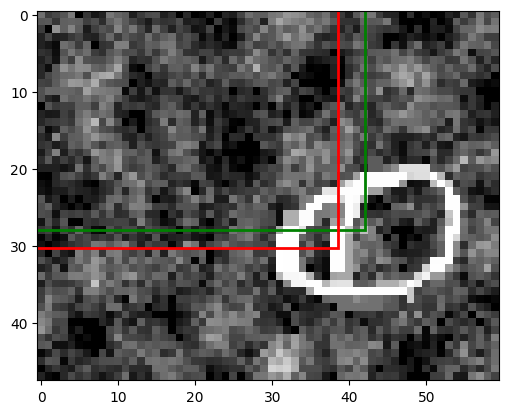

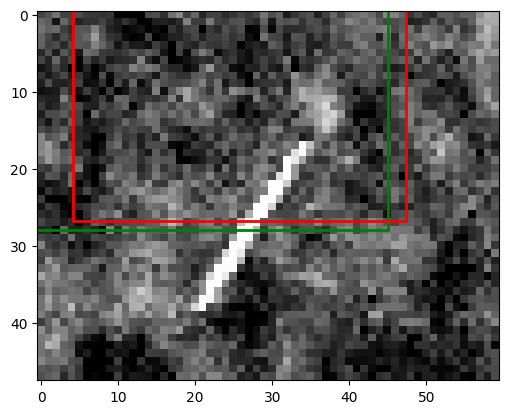

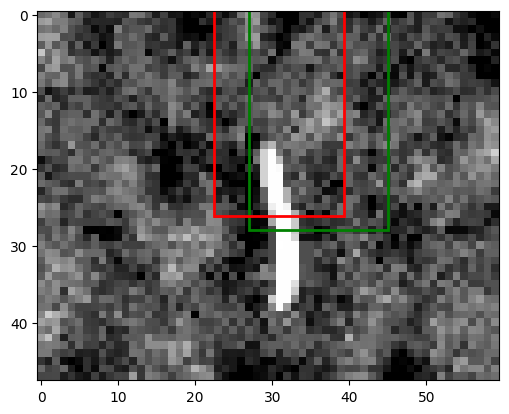

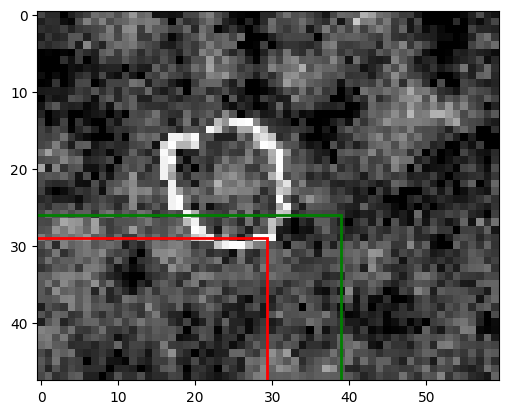

Visualizing random test samples with best model....


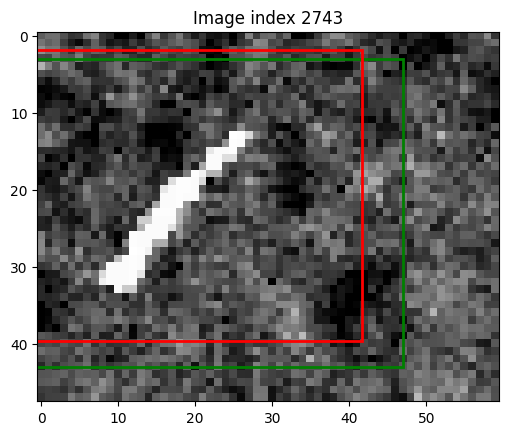

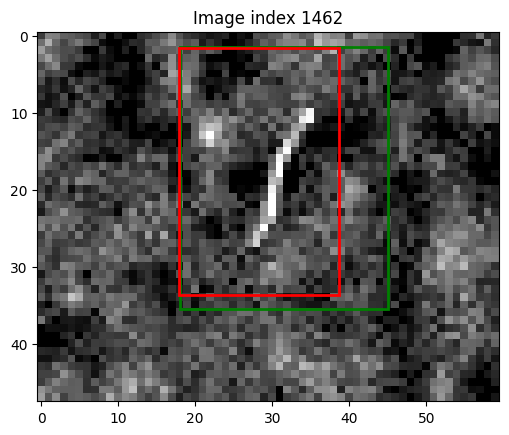

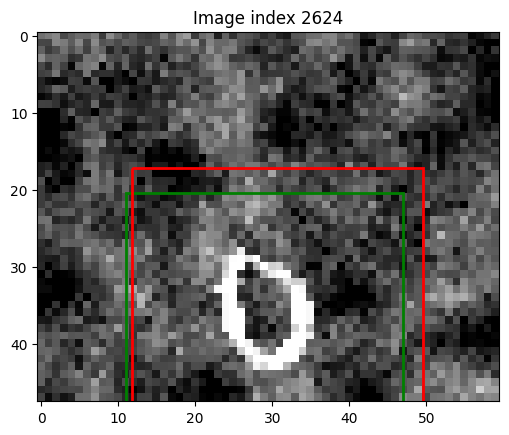

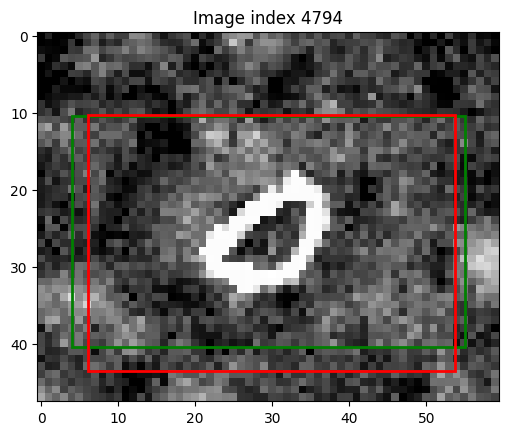

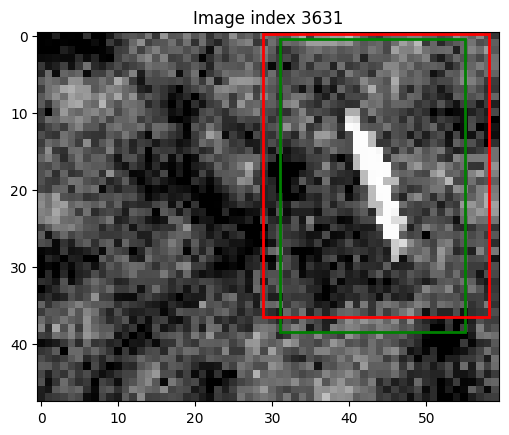

Finding best and worst predictions for best model...
Best predictions (best model):


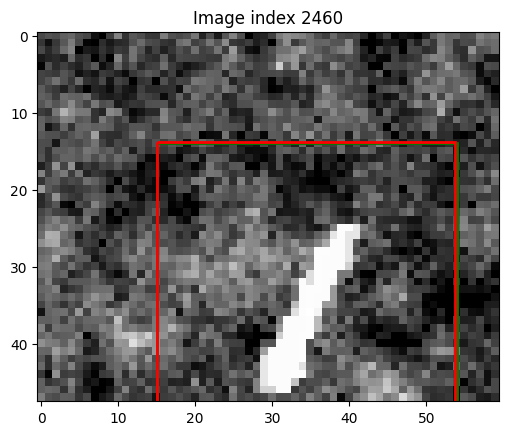

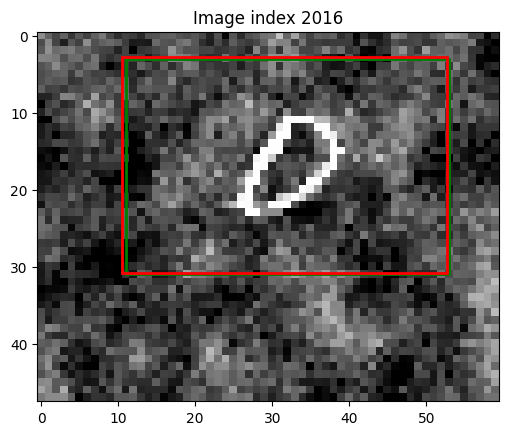

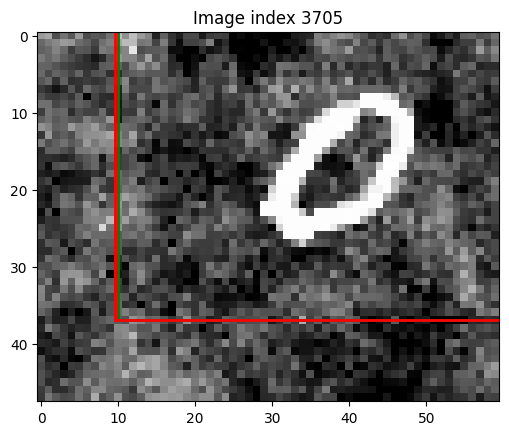

Worst predictions (best model):


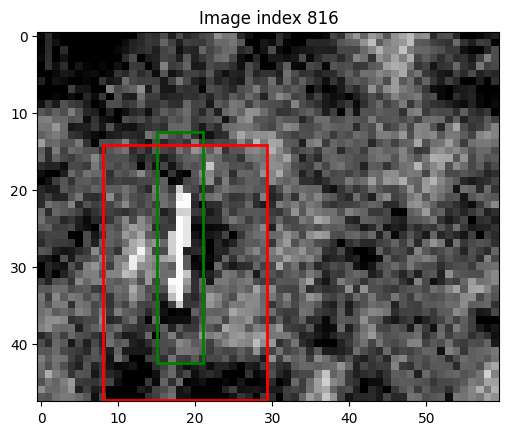

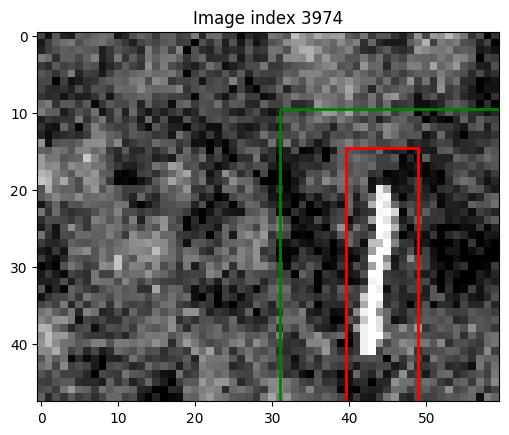

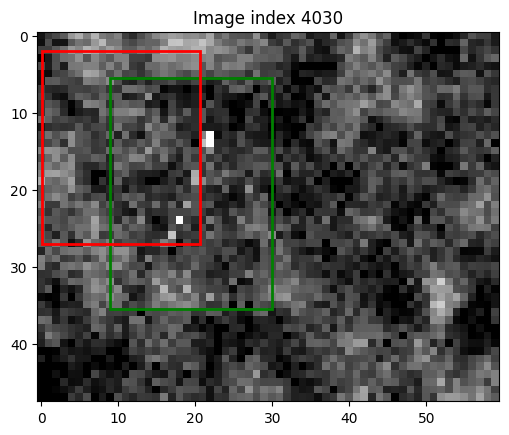

Finding best and worst predictions for improved model...
Best predictions (improved model):


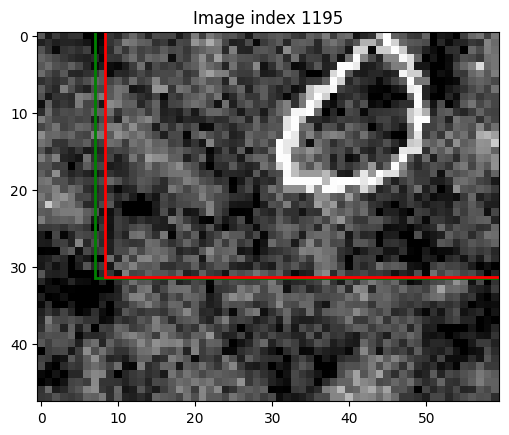

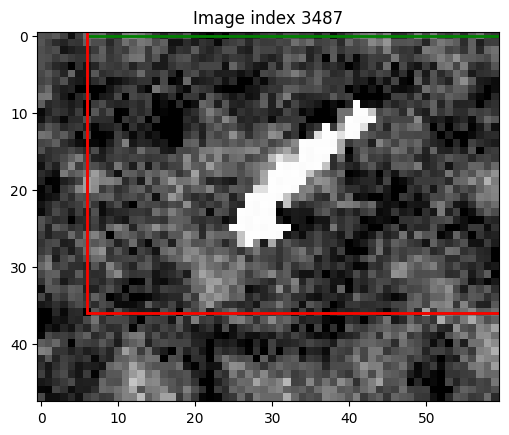

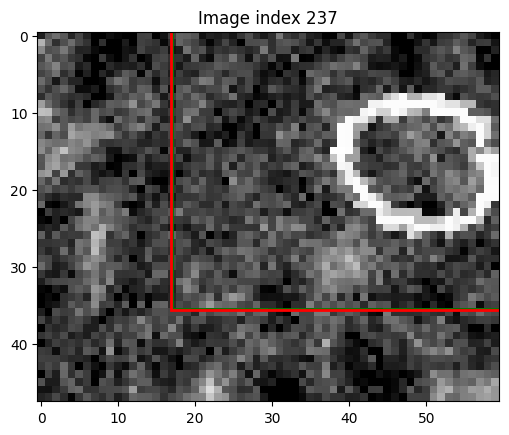

Worst predictions (improved model):


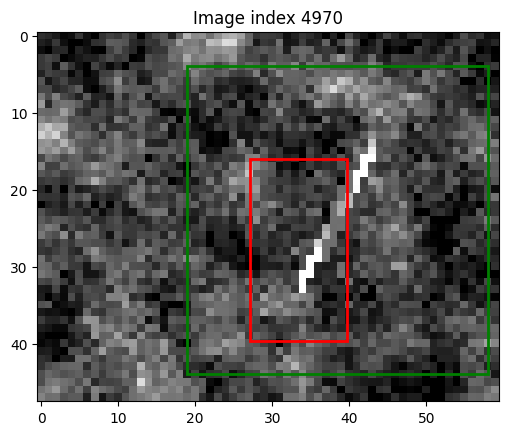

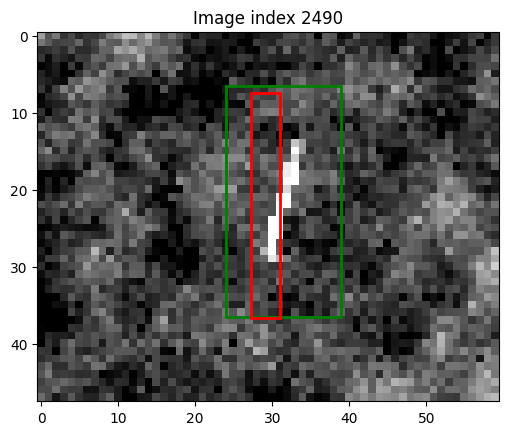

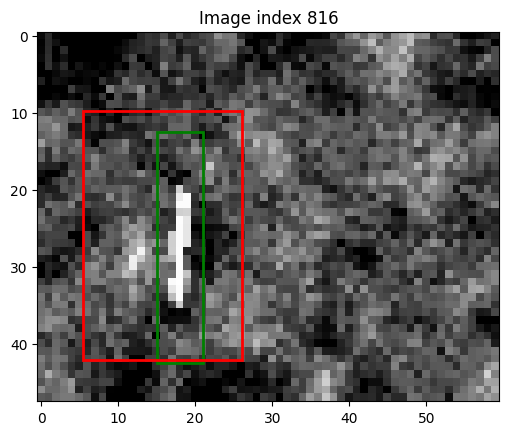

In [47]:
# Visualiser prediksjoner for best_model
plot_predictions(best_model, test_loader)

### Visualisering av bounding boxes, inkludert improved_model hvis ønskelig
def visualize_bounding_boxes():
    """
    Demonstrate the bounding box visualization functions.
    """
    print("Visualizing random test samples with best model....")
    plot_images_with_bboxes(best_model, test_dataset, num_images=5)
    
    print("Finding best and worst predictions for best model...")
    best_indices, worst_indices = find_best_and_worst_predictions(best_model, test_dataset, n_samples=3)
    
    print("Best predictions (best model):")
    plot_images_with_bboxes(best_model, test_dataset, indices=best_indices)
    
    print("Worst predictions (best model):")
    plot_images_with_bboxes(best_model, test_dataset, indices=worst_indices)
    
    # Hvis du ønsker å se improved_model separat, kan du hente den ut fra trained_models-lista
    improved_entry = next((x for x in trained_models if x["model_name"] == "ImprovedDetectNet"), None)
    if improved_entry is not None:
        improved_model = improved_entry["model"]
        print("Finding best and worst predictions for improved model...")
        best_indices_improved, worst_indices_improved = find_best_and_worst_predictions(improved_model, test_dataset, n_samples=3)
        print("Best predictions (improved model):")
        plot_images_with_bboxes(improved_model, test_dataset, indices=best_indices_improved)
        print("Worst predictions (improved model):")
        plot_images_with_bboxes(improved_model, test_dataset, indices=worst_indices_improved)
    else:
        print("ImprovedDetectNet was not trained.")

# Kjør visualiseringen
visualize_bounding_boxes()
